In [ ]:
!pip install kaggle

In [ ]:
!mkdir /root/.kaggle
!cp ./kaggle.json /root/.kaggle

In [ ]:
import kaggle
kaggle.api.authenticate()

In [ ]:
kaggle.api.dataset_download_files('staratnyte/cigarcropdamage', path='./data')

In [ ]:
!unzip /content/data/cigarcropdamage.zip

Streaming output truncated to the last 5000 lines.
  inflating: images/images/dba3ace3e7da3f2f7809d29f9fe3e023d97ff21f.jpg  
  inflating: images/images/dba708ae7f19e01e606a001439ff08414184c011.jpg  
  inflating: images/images/dbab489272a85c5b992265b9a706c4ba021d04ed.jpg  
  inflating: images/images/dbaf40604fe7a36462628d07588099a4f0662025.jpg  
  inflating: images/images/dbaffe51b6a6634253932a1f7d1b43d9f33b921f.jpg  
  inflating: images/images/dbb32135905344db4ca511336f264148e60395ec.jpg  
  inflating: images/images/dbb4138dd9fadfe0d840d8bad497e74e576fe87d.jpg  
  inflating: images/images/dbb44019c7300358d02716b92743a630b88650b7.jpg  
  inflating: images/images/dbb5a8a3fd95d144966e65e014c9bca851ccfdac.jpg  
  inflating: images/images/dbb8cc3e48d8f1901b638fd0d974599ed2186cb1.jpg  
  inflating: images/images/dbb8f2af1e1f4d7c36bba038c723f902b41b43d7.jpg  
  inflating: images/images/dbba90b006f28434c19c4065242fd0e17e18cf3e.jpg  
  inflating: images/images/dbbab2e2b7df1ff0ef98ea5582c312fab6

In [ ]:
!pip install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 25.8 MB/s eta 0:00:00


In [ ]:
from fastai.vision.all import *
set_seed(42)

In [ ]:
trn_path = '/content/images/images'
files    = get_image_files(trn_path)

In [ ]:
Train            = pd.read_csv('/content/Train.csv')
Test             = pd.read_csv('/content/Test.csv')
SampleSubmission = pd.read_csv('/content/SampleSubmission.csv')

In [ ]:
from fastcore.parallel import *
def f(o): return PILImage.create(o).size
sizes = parallel(f, files, n_workers=8)

In [ ]:
damage = Train.damage.unique()

In [ ]:
dblock = DataBlock(blocks = (ImageBlock, CategoryBlock(vocab=damage)),
                   get_x = ColReader('filename', pref = '/content/images/images/'),
                   get_y = ColReader('damage'),
                   splitter = RandomSplitter(valid_pct = 0, seed = 42),
                   item_tfms = Resize(256, method = 'squish'),
                   batch_tfms = aug_transforms(size = 224, min_scale = 0.75)
                  )

dls = dblock.dataloaders(Train)

In [ ]:
learn = vision_learner(dls, 'vit_base_patch16_224_in21k', loss_func = nn.CrossEntropyLoss(), metrics=accuracy).to_fp16()

/usr/local/lib/python3.10/dist-packages/timm/models/_factory.py:117: UserWarning: Mapping deprecated model name vit_base_patch16_224_in21k to current vit_base_patch16_224.augreg_in21k.
  model = create_fn(


SuggestedLRs(valley=0.0014454397605732083, slide=0.00363078061491251)

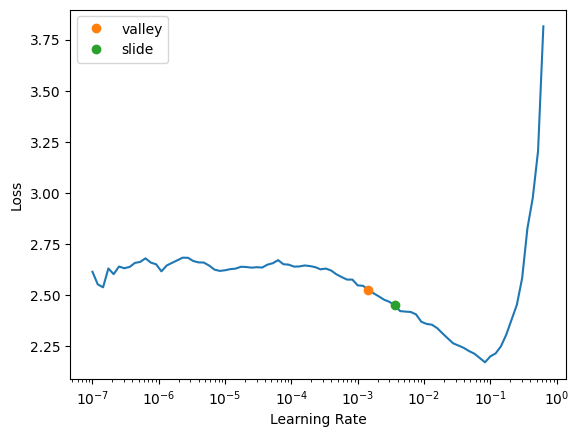

In [ ]:
learn.lr_find(suggest_funcs=(valley,slide))

In [ ]:
learn.fine_tune(10, 0.001)

epoch,train_loss,valid_loss,accuracy,time
0,1.053671,None,None,12:35


/usr/local/lib/python3.10/dist-packages/fastprogress/fastprogress.py:73: UserWarning: Your generator is empty.
  warn("Your generator is empty.")


epoch,train_loss,valid_loss,accuracy,time
0,0.839533,None,None,16:47
1,0.746733,None,None,16:42


In [ ]:
test_dl = learn.dls.test_dl('/content/images/images/' + Test['filename'])
preds , _ = learn.get_preds(dl=test_dl)

In [ ]:
preds = F.softmax(preds, dim=1)

In [ ]:
submission_sf = pd.DataFrame({

    'ID': Test['ID'],
    'DR': preds[:, 0].squeeze().numpy(),
    'G' : preds[:, 1].squeeze().numpy(),
    'ND': preds[:, 2].squeeze().numpy(),
    'WD': preds[:, 3].squeeze().numpy(),
    'other': preds[:, 4].squeeze().numpy(),
})

In [ ]:
submission_sf.head(5)

,ID,DR,G,ND,WD,other
0,ID_QW9GQM,0.001733,0.829329,0.000145,0.168160,0.000633
1,ID_G9VPQ9,0.017831,0.826216,0.011268,0.065493,0.079193
2,ID_QIMIEM,0.000252,0.256902,0.000043,0.741920,0.000883
3,ID_TSINUQ,0.000210,0.753595,0.000016,0.245135,0.001045
4,ID_I7OOHH,0.041607,0.641375,0.000904,0.315649,0.000465


In [ ]:
submission_sf.to_csv('vit_16_224_in21k_alldata.csv', index=False)

In [ ]:
learn.export('vit_16_224_alldata_001.pkl')